## Working with Ellipsoids

In this notebook we compute intersections of ellipsoids using LazySets.

In [1]:
# load the sets library and the plotting library
using LazySets, Plots

An ellipsoid $E$ can be created by giving its center $c$ and its shape matrix $Q$, which should be positive definite, i.e. its eigenvaues must be positive. Mathematically, it is the set $E = \{ x \in \mathbb{R}^n : (x-c)Q^{-1}(x-c) \leq 1\}$.

Let's make two rotated ellipsoids and plot them in the same pair of axes.

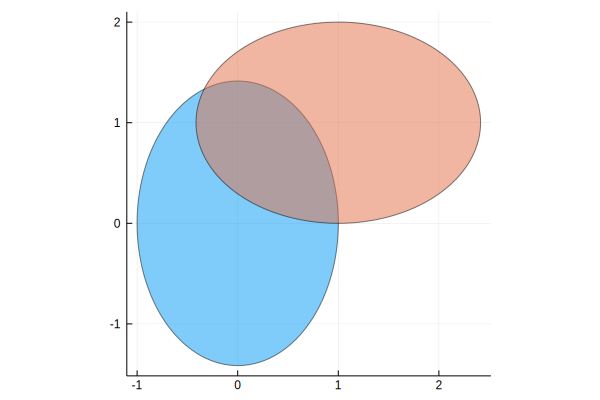

In [2]:
E₁ = Ellipsoid(zeros(2), [1 0; 0 2.])
E₂ = Ellipsoid(ones(2), [2 0; 0 1.])

pell = plot(E₁, 1e-3, aspectratio=1, alpha=.5)
pell = plot!(pell, E₂, 1e-3, alpha=.5)

*Note.* If you are wondering about the paremeter $1e-3$ passed to `plot`, this parameter controls the accuracy to which the set is plotted (because the set that we actually plot is a polygonal overapproximation of the ellipses!).

Now let's take the *lazy* intersection of the ellipses:

In [3]:
E₁ ∩ E₂

Intersection{Float64,Ellipsoid{Float64},Ellipsoid{Float64}}(Ellipsoid{Float64}([0.0, 0.0], [1.0 0.0; 0.0 2.0]), Ellipsoid{Float64}([1.0, 1.0], [2.0 0.0; 0.0 1.0]), LazySets.IntersectionCache(-1))

On the other hand, the *concrete* intersection of sets, called `intersection` in LazySets, is not yet available for ellipsoids:

In [4]:
hasmethod(intersection, Tuple{typeof(E₁), typeof(E₂)})

false

So how can we work with the intersection of the ellipsoids?

One way is to overapproximate them by polygons (or polytopes in higher dims) and then take their intersection, because this function is defined, whose return type is again a `HPolytope`:

In [5]:
hasmethod(intersection, Tuple{HPolytope{Float64}, HPolytope{Float64}})

true

In [6]:
import LazySets.Approximations.overapproximate

# the parameter epsilon controls the accuracy of the iterative refinement,
# with respect to the Hausdorff distance
H₁(ε) = overapproximate(E₁, HPolygon, ε)
H₂(ε) = overapproximate(E₂, HPolygon, ε)

# using the concrete hpolytope-hpolytope intersection here
Hint(ε) = intersection(convert.(HPolytope, [H₁(ε), H₂(ε)])...);

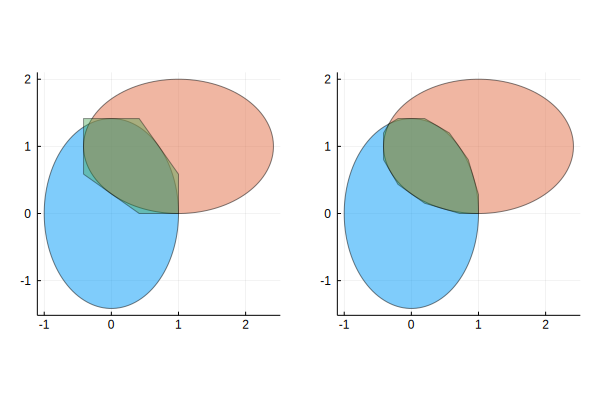

In [7]:
pell = plot(E₁, 1e-3, aspectratio=1, alpha=.5)
pell = plot!(pell, E₂, 1e-3, alpha=.5)
pεsmaller = plot!(pell, convert(HPolygon, Hint(0.5)), alpha=.4)

pell = plot(E₁, 1e-3, aspectratio=1, alpha=.5)
pell = plot!(pell, E₂, 1e-3, alpha=.5)
pεbigger = plot!(pell, convert(HPolygon, Hint(0.05)), alpha=.4)

plot(pεsmaller, pεbigger, layout=(1, 2))

Note how dividing the $\varepsilon$ threshold by 10 makes the polygonal overapproximation of the intersection tighter.

Yet another approach is to directly query the directions of the *lazy* intersection `E₁ ∩ E₂`. We can overapproximate using template directions, such as a box, an octagon, or other.

This method is actually more efficient, because we don't have to calculate the polytopic overapproximations of the ellipsoids, but only the support function of the (lazy) intersection.

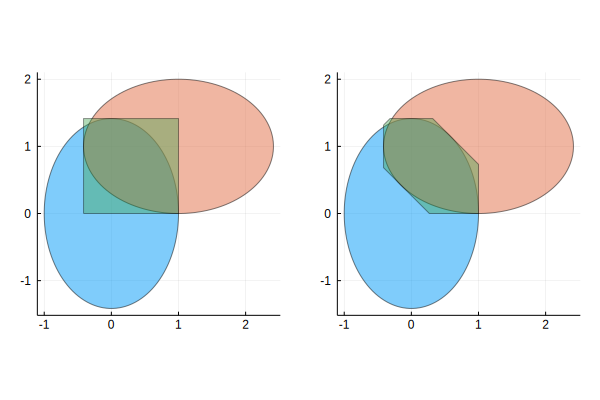

In [8]:
import LazySets.Approximations.overapproximate
using LazySets.Approximations, Polyhedra

# overapproximate the lazy intersection using a box
Xbox = overapproximate(E₁ ∩ E₂, BoxDirections(2))

# overapproximate the lazy intersection using octagonal directions
Xoct = overapproximate(E₁ ∩ E₂, OctDirections(2))

pell = plot(E₁, 1e-3, aspectratio=1, alpha=.5)
pell = plot!(pell, E₂, 1e-3, alpha=.5)
pbox = plot!(pell, Xbox, alpha=.4)

pell = plot(E₁, 1e-3, aspectratio=1, alpha=.5)
pell = plot!(pell, E₂, 1e-3, alpha=.5)
poct = plot!(pell, Xoct, alpha=.4)

plot(pbox, poct, layout=(1, 2))

The idea behind the template overapproximation method is to use the property that the support function of the intersection of two convex sets is upper bounded by the max of the support function of each set. We can see in this experiment that the resulting set is quite tight.

Let's time it!

In [9]:
using BenchmarkTools

@btime overapproximate($E₁ ∩ $E₂, BoxDirections(2))
@btime overapproximate($E₁ ∩ $E₂, OctDirections(2));

  9.208 μs (133 allocations: 4.94 KiB)
  18.279 μs (246 allocations: 9.88 KiB)


We can work with higher dimensional ellipsoids as well:

In [10]:
using LinearAlgebra

# a random ellipsoid in n-dimensions
function rand_ellipsoid(n)
    A = rand(n,n)
    Q = (A+transpose(A))/2 + n * I
    Ellipsoid(rand(n), Q)
end

rand_ellipsoid (generic function with 1 method)

In [11]:
for n in [2, 5, 50, 100]
    println("\nn = $n\n")
    E₁, E₂ = rand_ellipsoid(n), rand_ellipsoid(n)

    # overapproximate the lazy intersection using an n-dimensional box
    @btime overapproximate($E₁ ∩ $E₂, OctDirections($n))
    
    # overapproximate the lazy intersection using octagonal directions in R^n
    @btime overapproximate($E₁ ∩ $E₂, BoxDirections($n))
end;


n = 2

  18.377 μs (246 allocations: 9.88 KiB)
  9.295 μs (133 allocations: 4.94 KiB)

n = 5

  129.476 μs (1412 allocations: 70.52 KiB)
  26.384 μs (325 allocations: 13.98 KiB)

n = 50

  20.131 ms (135518 allocations: 22.61 MiB)
  633.351 μs (3205 allocations: 382.27 KiB)

n = 100

  144.896 ms (541020 allocations: 144.23 MiB)
  3.040 ms (6405 allocations: 1.15 MiB)
